# Neural Style Transfer for Images USing VGG19 Model
## CPCS-433 Course Project: Neural Style Transfer 
## Group Members: Reem Alghamdi, Sarah Al-jumai, Joud Alsuhaibani 


This notebook has been created to test the NST algorithm. 
source code from this github repository: https://github.com/david-adewoyin/NeuralStyleTransfer/blob/main/neural_style_transfer.ipynb
with our own modifications on the code 

# Step 1: importing libraries

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt 
from PIL import Image 
import torch.nn as nn 
import torch
from torchvision import transforms 
from torchvision.utils import save_image 
import tensorflow as tf

#from keras.preprocessing import image as kp_image
from tensorflow.keras import models 
from tensorflow.keras import losses
from tensorflow.keras import layers
from tensorflow.keras import backend as K

from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.utils import load_img as kp_image
#from tensorflow.keras.utils import img_to_array

# Step 2: kaggle dataset

In [ ]:
#kaggle API key fiel
from google.colab import files
uploaded=files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
#create kaggle folder
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
#access kaggle datasets
!kaggle datasets list

ref                                                             title                                       size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  -----------------------------------------  -----  -------------------  -------------  ---------  ---------------  
akshaydattatraykhare/diabetes-dataset                           Diabetes Dataset                             9KB  2022-10-06 08:55:25          15030        441  1.0              
akshaydattatraykhare/data-for-admission-in-the-university       Data for Admission in the University         4KB  2022-10-27 11:05:45           3592         80  1.0              
aneesayoub/world-universities-ranking-2022                      World Universities Ranking 2022             41KB  2022-11-17 03:47:37           1009         28  0.9117647        
whenamancodes/covid-19-coronavirus-pandemic-dataset             COVID -19 Coronavirus Pandemic Dataset   

In [ ]:

!kaggle datasets download -d ikarus777/best-artworks-of-all-time

100% 2.29G/2.29G [01:48<00:00, 19.5MB/s]
100% 2.29G/2.29G [01:48<00:00, 22.7MB/s]


In [ ]:
!unzip  "/content/best-artworks-of-all-time.zip" -d "/content" &> /dev/null


In [ ]:
imgs = []
for dirname, _, filenames in os.walk('/content/resized/resized'):
  for filename in filenames:
    x = os.path.join(dirname, filename)
    if x.endswith('.jpg'):
      imgs.append(x)

In [ ]:
print('No. of images in the dataset: ',len(imgs))

No. of images in the dataset:  8683


### Randomly select a content image and a style image from the dataset. 
* Content image: the image that the NST algorithm will be performed on. 
* Style image: the image that its style will be implemented on the the content image. 

In [ ]:
def random_select(seed): 
    np.random.seed(seed)
    content = np.random.choice(imgs)
    print(content)
    style = np.random.choice(imgs)
    print(style)
    return content,style


In [ ]:
content_path='/content/resized/resized/Albrecht_DuтХа├кrer_111.jpg'
style_path='/content/resized/resized/Alfred_Sisley_72.jpg' 


#content_path,style_path = random_select(len(imgs))


# Adjust images:


In [ ]:
 IMG_WIDTH = 500
IMG_HEIGHT = 500

#content_image_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://user-images.githubusercontent.com/57121852/197607208-1d514b22-899c-4ee9-9966-b0325545c71f.jpg')
#style_image_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

## specifiying hyperparameters

In [ ]:
## Specifying the Hyperparameters of the network

ALPHA = 5e1         # weight to emphasis content loss
BETA = 1e-1         # weight to emphasis style loss

In [ ]:
## we using vgg as the backbone of our neural style transfer architecture
vgg = tf.keras.applications.vgg19.VGG19(
    include_top = False,
    input_shape = (IMG_HEIGHT,IMG_WIDTH,3),
)
vgg.trainable = False

# Print model summary

In [ ]:
vgg.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 500, 500, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 500, 500, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 500, 500, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 250, 250, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 250, 250, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 250, 250, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 125, 125, 128)     0     

To obtain a representation of the content image,we capture feature response in higher layers of the network, the idea being higher layers of the network captures information in terms of objects and their arrangment without paying attention to their exact pixel values.
While to obtain a representation of the style of an input image, we extract both low level features such as (textures,etc..) and high level representation from different layers to build a feature correlation of multiple layers with the purpose of capturing its texture information but not the global arrangement.

In [ ]:
## The names of the various layers of the vgg network we need for the style representation and the respective weight
STYLE_LAYERS = [
    ('block1_conv2',5),
    ('block2_conv2',0.5),
    ('block3_conv4',0.5),
    ('block4_conv4',1),
    ('block5_conv4',5),
]

## The name of the layer we need for the content representation
CONTENT_LAYER = [
   ('block5_conv2',1)
]

In [ ]:
layers = STYLE_LAYERS + CONTENT_LAYER

# we build our custom model on the vgg
# the model has multiple outputs given an input image corresponding to the output produced at the layers defined above
def custom_model(vgg,layers):
  input = vgg.input
  outputs = [vgg.get_layer(layer[0]).output for layer in layers]
  model = tf.keras.Model(inputs = input, outputs = outputs) 
  return model

In [ ]:
def load_img(image_path):
  img = tf.io.read_file(image_path)
  img = tf.image.decode_image(img,channels=3)
  img = tf.image.convert_image_dtype(img,tf.float32)
  # resize the image according while perserving the aspect ratio
  img  = tf.image.resize(img,(IMG_WIDTH,IMG_HEIGHT))
  # Tensorflow expect our image to have an extra dimension corresponding to the batch size (in this case 1)
  img  = tf.expand_dims(img,axis = 0)
  return img

In [ ]:
def imshow(image,title=None):
  if len(image.shape)>3:
    image = tf.squeeze(image,axis=0)
    plt.imshow(image)
    if title:
      plt.title(title)

In [ ]:
model = custom_model(vgg,layers)
content_img = load_img(content_path)
style_img   = load_img(style_path) 

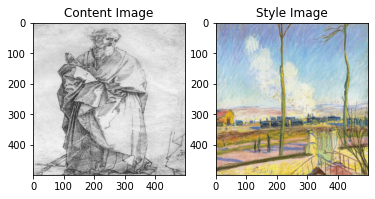

In [ ]:
plt.subplot(1,2,1)
imshow(content_img,'Content Image')

plt.subplot(1,2,2)
imshow(style_img,'Style Image')

In [ ]:
def content_cost(content_map,generated_map):
  # the content cost determines how well our generated_image matches the content image
  content_map = content_map[-1]
  generated_map = generated_map[-1]
  
  _,n_H,n_W,n_C = content_map.shape
  c_unrolled = tf.reshape(content_map, shape = [1,-1,n_C])
  g_unrolled = tf.reshape(generated_map, shape = [1,-1,n_C])

  #compute cost
  sq = tf.square(c_unrolled - g_unrolled)
  cost = tf.reduce_sum(sq)/(4*n_H*n_W*n_C)
  return cost

In [ ]:
# gram matrix is need to compute the style cost at each layer
# it tells us how similar the activation of one filter is to another filter in the same layer
def Gram_Matrix(A):
  A_t = tf.transpose(A)
  return tf.matmul(A,A_t)

In [ ]:
def style_at_layer_cost(style_map,generated_map):
  ## the cost is calcuated for each layer defined  in the STYLE_LAYERS
  _,n_H,n_W,n_C = style_map.shape
  s_unrolled = tf.transpose(tf.reshape(style_map, shape = [-1,n_C]))
  g_unrolled= tf.transpose(tf.reshape(generated_map, shape = [-1,n_C]))

  s_gram = Gram_Matrix(s_unrolled)
  g_gram = Gram_Matrix(g_unrolled)

  #compute cost
  sq = tf.square(s_gram - g_gram)
  cost = tf.reduce_sum(sq) /(4*(n_H * n_W *n_C)**2 )## (4 * n_H * n_W *n_C)**2 is based on the original paper
  return cost


In [ ]:
def style_cost(style_map,generated_map,STYLE_LAYERS = STYLE_LAYERS):
  # calculate the total cost across all layers

  style_map = style_map[:-1] ## fetch all style layers except the content layer
  generated_map = generated_map[:-1]
  
  cost = 0
  for i,weight in zip(range(len(style_map)),STYLE_LAYERS):
    J_style_layer = style_at_layer_cost(style_map[i],generated_map[i])
    cost += J_style_layer * weight[1]
  return cost


In [ ]:
def preprocess_image(image):
  img = tf.keras.applications.vgg19.preprocess_input(image*255.0)
  return img

In [ ]:
def generate_image(content_image):
  # generate an image from the combination of a noise and the content image
  generated_image = tf.Variable(tf.image.convert_image_dtype(content_image,tf.float32))
  noise_image = tf.random.uniform(tf.shape(generated_image),-0.1,0.1)

  generated_image = tf.add(generated_image,noise_image)
  generated_image = tf.clip_by_value(generated_image,clip_value_min =0.0, clip_value_max=1.0)

  return generated_image 


In [ ]:
def tensor_to_image(tensor):
  """
  Convert the given tensor into a PIL image
  """
  tensor = tensor *255.0
  tensor = np.array(tensor,dtype = np.uint8)
  if np.ndim(tensor) >3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return Image.fromarray(tensor)

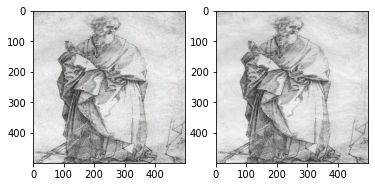

In [ ]:
content_image = tf.constant(preprocess_image(content_img))
style_image = tf.constant(preprocess_image(style_img))

generated_image = generate_image(content_img)
generated_image = tf.Variable(generated_image)

_,ax = plt.subplots(1,2)
ax[0].imshow(generated_image[0])
ax[1].imshow(content_img[0])

In [ ]:
a_S = model(style_image)
a_C =  model(content_image)

In [ ]:
optimizer = tf.keras.optimizers.Adam(0.02)
@tf.function()
def train_step(generated_image,variation_weight = 1):
  with tf.GradientTape() as tape:

    a = preprocess_image(generated_image)
    a_G = model(a)

    J_style   = style_cost(a_S,a_G)
    J_content = content_cost(a_C,a_G)

    J = ALPHA *J_content + BETA * J_style
    vari_loss =variation_weight * tf.reduce_sum(tf.image.total_variation(generated_image))
    J+= vari_loss

  grad = tape.gradient(J,generated_image)
  optimizer.apply_gradients([(grad,generated_image)])
  clipped = tf.clip_by_value(generated_image,0.0,1.0)
  generated_image.assign(clipped)
  return J

Epoch 500


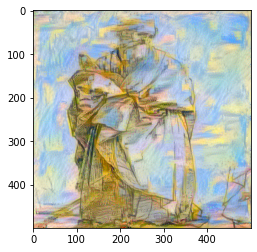

Epoch 1000


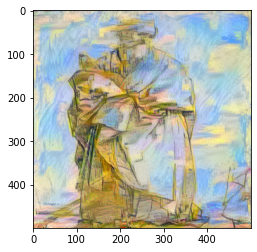

Epoch 1500


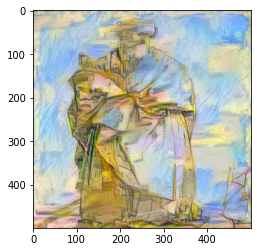

Epoch 2000


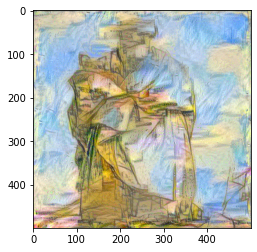

Epoch 2500


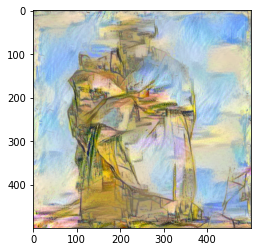

Epoch 3000


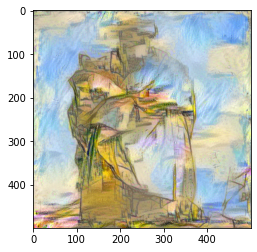

Epoch 3500


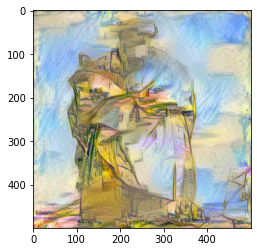

In [ ]:
epochs = 4_000
for i in range(epochs):
  train_step(generated_image,variation_weight=10)
  if i % 500 == 0 and i != 0 :
    print(f"Epoch {i}")
    image = tensor_to_image(generated_image)
    plt.imshow(image)
    plt.show()
    if i% 500 == 0:
      image.save(f"image{i}conv{i}.jpg")


In [ ]:
tensor_to_image(generated_image)
image.save(f"stylized.jpg")

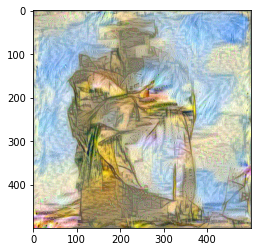

In [ ]:
imshow(generated_image)